# Inicialização e reconhecimento do banco

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np

import yaml
from stopwords import get_stopwords
import unicodedata
import re

In [2]:
import nltk
from nltk.tokenize import TweetTokenizer

In [4]:
import elasticsearch
from elasticsearch.helpers import scan, bulk

In [5]:
# Usar tunel
# $ ssh ubuntu@twitter-es.twist.systems -L10200:localhost:9200
es_conn = elasticsearch.Elasticsearch("localhost:10200", timeout=300)
es_conn.ping()

True

In [6]:
twitter_mapping = es_conn.indices.get_mapping(index="twitter_2015_09_01", doc_type="tweet")

In [7]:
twitter_mapping['twitter_2015_09_01']['mappings']['tweet']['properties'].keys()

dict_keys(['retweet_count', 'entities', 'in_reply_to_user_id_str', 'user_info', 'id', 'text', 'user', 'in_reply_to_status_id_str', 'retweeted_status', 'created_at', 'category', 'geo', 'is_rt', 'favorite_count', 'in_reply_to_screen_name', 'lang'])

In [8]:
query = yaml.safe_load("""
query:
    match_all: {}
size: 0
aggregations:
    users:
        terms:
            field: user
            size: 0
""")

results = es_conn.search(index="twitter_2015_09_01", doc_type="tweet", body=query)

In [9]:
pd.DataFrame.from_dict(results['aggregations']['users']['buckets'], orient="columns")

,doc_count,key
0,2771040,dilma
1,619591,rockinrio
2,197335,bienalrio
3,123220,timessquare
4,8917,tuenti
5,873,museu_do_amanha


# Tokenização

In [10]:
def doc_to_tweet(docs):
    for doc in docs:
        text = doc['_source'].get('text', '')
        if text:
            yield text

In [240]:
TOKENIZER = TweetTokenizer()
RE_JAJA = re.compile('^[jae]{2,}$')

def filter_tokens(tokens):
    
    for token in tokens:
        if RE_JAJA.match(token.lower()):
            yield "jaja"
        else:
            yield token

def tokenize_tweets(tweets):
    tokenizer = TOKENIZER
    for tweet in tweets:
        # Perform normalization of unicode characters
        #tweet = unicodedata.normalize("NFC", tweet)
        tweet = ''.join(unicodedata.normalize('NFD', x)[0] for x in tweet)

        tokens = tokenizer.tokenize(tweet)
  
        yield list(filter_tokens(tokens))

In [241]:
query = yaml.safe_load("""
query:
    filtered:
        filter:
            bool:
                must:
                #- range:
                #    created_at:
                #        gte: 2015-10-26
                - term:
                    user: tuenti
                - term:
                    is_rt: false
_source:
    include:
    - user_info.screen_name
    - created_at
    - text
    - id
""")

docs = scan(es_conn, index="twitter_2015_09_01", doc_type="tweet", query=query, size=1000)
docs_df = pd.DataFrame.from_dict(
    (
        {
            "twitter_id": doc["_source"]["id"],
            "screen_name": doc["_source"]["user_info"]["screen_name"],
            "created_at": pd.to_datetime(doc["_source"]["created_at"]),
            "text": doc["_source"].get("text","")
        } for doc in docs),
    orient="columns"
)

In [242]:
tweets_over_time = docs_df.groupby(pd.Grouper(key="created_at", freq="1h")).size()

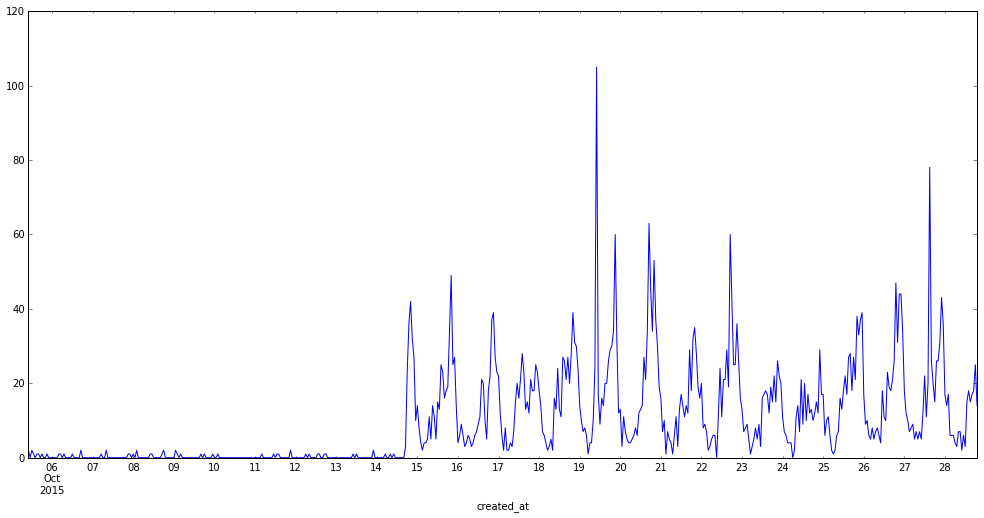

In [243]:
tweets_over_time.plot(figsize=(17,8))

In [244]:
# Tokenize
docs_df['tokenized'] = pd.Series(tokenize_tweets(docs_df['text'].values), index=docs_df.index)

In [245]:
docs_df

,created_at,screen_name,text,twitter_id,tokenized
0,2015-10-18 20:44:41,UnfinishedXIII,Dame tu Tuenti wapa ;$$$$,655846989477859329,"[Dame, tu, Tuenti, wapa, ;, $, $, $, $]"
1,2015-10-18 21:24:39,rauleldelbaul,@brendamarting conozco a quien ve Twitter como...,655857047360131073,"[@brendamarting, conozco, a, quien, ve, Twitte..."
2,2015-10-19 10:08:22,karol_paulino,"""En España no hay ninguna empresa tecnológica ...",656049239324168192,"["", En, Espana, no, hay, ninguna, empresa, tec..."
3,2015-10-19 10:33:15,SoositaX,.@MisterPekas @castanyer_ @CunadoDeTuiter Tuen...,656055504356188161,"[., @MisterPekas, @castanyer_, @CunadoDeTuiter..."
4,2015-10-19 12:30:41,TuentiAR,@wboneder (...) por acá http://t.co/EzNE8mk2Yo...,656085056994299904,"[@wboneder, (, ..., ), por, aca, http://t.co/E..."
5,2015-10-19 13:20:22,RafaelBartolome,First day at Tuenti. Lots of things to learn. ...,656097560592044032,"[First, day, at, Tuenti, ., Lots, of, things, ..."
6,2015-10-19 13:31:42,RITdVil,Yo en épocas de Tuenti si alguien salía mal en...,656100411435261952,"[Yo, en, epocas, de, Tuenti, si, alguien, sali..."
7,2015-10-19 15:35:50,WDanielGarrido4,"Antes de Twitter, teníamos Tuenti. Antes de Tu...",656131652360515584,"[Antes, de, Twitter, ,, teniamos, Tuenti, ., A..."
8,2015-10-19 17:12:33,JaviEsMatute,A todos que siguen utilizando normalmente Tuen...,656155989692018688,"[A, todos, que, siguen, utilizando, normalment..."
9,2015-10-19 17:09:04,AidaRF53,¿Alguien que sea de Tuenti móvil?,656155114407895040,"[¿, Alguien, que, sea, de, Tuenti, movil, ?]"


# Seleção de Termos

In [305]:
stopwords = set(get_stopwords('es'))

stopwords |= set([
        'tuenti',
        'rt',
        'va',
        'voy',
        'ser',
        'voy',
        'si',
        'ver',
        'ahora',
        'solo',
        'mas',
        'dos',
        'tres',
        '#tuenti',
        '@tuenti',
        'asi',
        'tambien',
        'alguien',
        'hoy',
        '$',
        'da',
        'mia',
        '|',
        '^',
        '+',
        '>',
        '<',
        '€',
        '='
    ])

In [306]:
terms = nltk.FreqDist()

for tweet in docs_df['tokenized'].values:
    terms.update(set(x.lower() for x in tweet))
    
terms = sorted(terms.items(), key=lambda x: x[1], reverse=True)

In [307]:
terms = (x for x in terms if x[0] not in stopwords)
terms = (x for x in terms if (unicodedata.category(x[0][0])[0] in "LS") or (x[0][0] in '@#'))
terms = (x for x in terms if not ((unicodedata.category(x[0][0])[0] == "L") and (len(x[0]) < 2)))
terms = (x for x in terms if not x[0].startswith('http'))
terms = (x for x in terms if x[1] > (docs_df.shape[0]*0.001))
terms = list(terms)

In [308]:
print('\n'.join("%3d - %s" % (x[1], x[0]) for x in terms[-50:]))

  6 - #facebookasqueroso
  6 - llegar
  6 - conversacion
  6 - realizar
  6 - aparte
  6 - mandado
  6 - full
  6 - cierto
  6 - culo
  6 - edad
  6 - ke
  6 - importante
  6 - 😁
  6 - jovenes
  6 - monton
  6 - palabra
  6 - #20up
  6 - nose
  6 - quisiera
  6 - escrito
  6 - #telefonica
  6 - escribe
  6 - contrato
  6 - dignidad
  6 - breathe
  6 - existiendo
  6 - metio
  6 - ponen
  6 - cambio
  6 - laura
  6 - ecuador
  6 - dais
  6 - adeyemi
  6 - nota
  6 - cotillear
  6 - portabilidad
  6 - @xatakamovil
  6 - #comparacionnivelexperto
  6 - puse
  6 - primero
  6 - use
  6 - ultimamente
  6 - acuerdas
  6 - entero
  6 - moviles
  6 - ingresa
  6 - celu
  6 - abro
  6 - basura
  6 - virgin


In [309]:
terms_with_symbols = [x for x in terms if (unicodedata.category(x[0][0])[0] == 'S')]
print('\n'.join("%3d - %s - %s" % (x[1], unicodedata.category(x[0][0]), x[0]) for x in terms_with_symbols))

326 - So - 😂
 28 - So - 😏
 25 - So - 😳
 20 - So - 👌
 19 - So - 😍
 18 - So - ❤
 18 - So - 😎
 16 - So - 😭
 14 - So - 😱
 13 - So - 🙈
 13 - Sm - <3
 12 - So - 😅
 10 - So - ♫
 10 - So - 😘
  9 - So - 😉
  9 - So - 😹
  9 - So - 😌
  9 - So - 👍
  9 - So - 😜
  8 - So - ✋
  8 - So - 😔
  8 - So - 👉
  8 - So - 🎉
  7 - So - 🌚
  7 - So - 😢
  7 - So - 💕
  6 - So - 😩
  6 - So - 😁


In [310]:
print(len(terms))


833


In [311]:
wordlist = [x[0] for x in terms]

In [312]:
pd.to_pickle(wordlist, 'wordlist.p')